In [5]:
pip install simpy

  Using cached simpy-4.1.1-py3-none-any.whl.metadata (6.1 kB)
Using cached simpy-4.1.1-py3-none-any.whl (27 kB)
Note: you may need to restart the kernel to use updated packages.


In [6]:
import simpy
import numpy as np
import matplotlib.pyplot as plt
import random

In queuing theory, the average waiting time in a system depends significantly on the number of servers and the arrival and service rates. For a single-server system, known as an M/M/1 queue, the average waiting time in the queue, denoted as $W_q(1)$, is given by:

\begin{equation}
W_q(1) = \frac{\rho}{\mu (1 - \rho)}
\end{equation}

where $\rho = \frac{\lambda}{\mu}$ is the traffic intensity, $\lambda$ is the arrival rate, and $\mu$ is the service rate.

The average time a customer spends in the system, $W(1)$, including both waiting and service time, is:

\begin{equation}
W(1) = W_q(1) + \frac{1}{\mu} = \frac{1}{\mu - \lambda}
\end{equation}

As the system load $\rho$ increases (i.e., as the arrival rate approaches the service rate), the waiting time increases significantly due to higher congestion.

For a multi-server system, such as an M/M/n queue with $n$ servers, the average waiting time is generally shorter. Considering an M/M/2 queue as an example, the probability that there are zero customers in the system, $P_0$, can be calculated without using summations by expanding the terms of the following equation:

\begin{equation}
P_0 = \left( \sum_{k=0}^{n-1} \frac{a^k}{k!} + \frac{a^n}{n!(1 - \rho)} \right)^{-1}
\end{equation}

With $a = \lambda/\mu $, which gives:

\begin{equation} P_0 = \left( \frac{(\lambda/\mu)^0}{0!} + \frac{(\lambda/\mu)^1}{1!} + \frac{(\lambda/\mu)^2}{2!(1 - \rho)} \right)^{-1} \end{equation}

Simplifying, this becomes:

\begin{equation}
P_0 = \left( 1 + \frac{\lambda}{\mu} + \frac{(\lambda/\mu)^2}{2(1 - \rho)} \right)^{-1}
\end{equation}

The probability that an arriving customer has to wait, $P_w$, is calculated as:

\begin{equation}
P_w = \frac{(\lambda/\mu)^2}{2(1 - \rho)} P_0
\end{equation}

The average waiting time in the queue for the M/M/2 system is then:

\begin{equation}
W_q(2) = \frac{P_w}{2\mu(1 - \rho)}
\end{equation}

The average time a customer spends in the system is:

\begin{equation}
W(2) = W_q(2) + \frac{1}{\mu}
\end{equation}

Due to the presence of multiple servers in the M/M/2 queue, the probability that a customer has to wait ($P_w$) is lower than in the M/M/1 queue. This results in a shorter average waiting time in the queue ($W_q(2) < W_q(1)$), and therefore, the total average time in the system is also shorter:

\begin{equation}
W(2) < W(1)
\end{equation}

This demonstrates that multi-server systems can handle the same load more efficiently than single-server systems, leading to reduced waiting times and improved performance.

The shorter average waiting time in an M/M/2 queue compared to an M/M/1 queue with the same system load $\rho$ can be explained intuitively. In the M/M/2 system, two servers share the workload, reducing the likelihood that both servers are busy at the same time. This means that arriving customers are less likely to encounter a busy system and have to wait. The system benefits from resource pooling, where the variability in arrival and service times is better absorbed due to the availability of multiple servers. This leads to shorter queues and reduced waiting times compared to a single-server system.

By comparing these two systems, it becomes clear that the average waiting time and overall system performance are heavily influenced by the number of servers and the scheduling algorithms employed. Multi-server systems with efficient scheduling can significantly improve performance, especially under high load conditions.

In [7]:
#Theoretical

def theoretical(Lambda, mu, n):

    rho = Lambda / (n * mu)
    a = Lambda/mu
    P0 = (sum((a)**k / np.math.factorial(k) for k in range(n)) + ((a)**n / (np.math.factorial(n) * (1 - rho))))**(-1)
    Pw = ((a**n)/ (np.math.factorial(n) * (1 - rho))) * P0

    Wqn = Pw / (n * mu * (1 - rho))

    return Wqn

In [8]:
import scipy.stats as st

# Used as a guide: https://simpy.readthedocs.io/en/latest/examples/bank_renege.html
def source(env, time_total, Lambda, counter, waiting_times, mu):
    """Generates customers and puts them into the queue."""

    for i in range(time_total):
                
        c = customer(env, f'Customer{i:02d}', counter, waiting_times, mu)
        env.process(c)
        t = random.expovariate(Lambda)

        yield env.timeout(t)

def customer(env, name, counter, timer, mu):
    """Customer process for FIFO scheduling."""

    arrive = env.now
    with counter.request() as req:

        yield req
        wait = env.now - arrive
        timer.append(wait)

        time_in = random.expovariate(mu)
        yield env.timeout(time_in)

def run_simulation(num_servers, N, Lambda, mu, time_total):
    
    timer = []

    for test in range(N):

        env = simpy.Environment()

        counter = simpy.Resource(env, capacity=num_servers)
 
        env.process(source(env, time_total, Lambda, counter, timer, mu))

        env.run()

    average = np.mean(timer)
    ci = st.t.interval(0.95, len(timer) -1, loc=average, scale=st.sem(timer))
    error = (ci[1] - ci[0]) / 2
    return average, error

C:\Users\A\AppData\Local\Temp\ipykernel_16556\3884741595.py:7: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  P0 = (sum((a)**k / np.math.factorial(k) for k in range(n)) + ((a)**n / (np.math.factorial(n) * (1 - rho))))**(-1)
C:\Users\A\AppData\Local\Temp\ipykernel_16556\3884741595.py:8: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  Pw = ((a**n)/ (np.math.factorial(n) * (1 - rho))) * P0


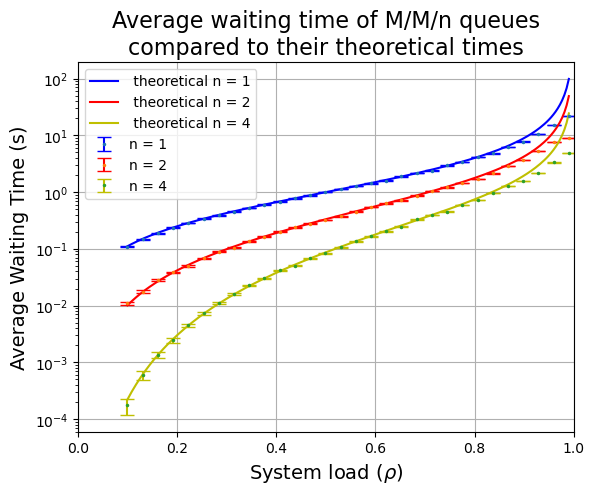

In [9]:
# Trying again for different load values


load = np.linspace(0.1, 0.99, 30)

mu = 1
time_total = 1000
#amount of repeats
N = 100
for servers in [1,2,4]:
 
    collected_times = []
    errors = []

    for value in load:

        Lambda = value * servers * mu

        result, error = run_simulation(servers, N, Lambda, mu, time_total)
        collected_times.append(result)
        errors.append(error)


    if servers == 1:
        tag = 'b'
    elif servers == 2:
        tag = 'r'
    elif servers == 4:
        tag = 'y'
    plt.errorbar(load, collected_times, yerr=errors, 
                        label = f'n = {servers}', ecolor =tag, fmt= '.',
                        capsize=5,markersize=3)
    #plt.plot(load, collected_times,'.', color =tag, label = f'n = {servers}')


load = np.linspace(0.1, 0.99, 200)

for servers in [1,2,4]:
 
    theoretical_times = []

    for value in load:

        Lambda = value * servers * mu

        result = theoretical(Lambda, mu, servers)
        theoretical_times.append(result)

    if servers == 1:
        tag = 'b'
    elif servers == 2:
        tag = 'r'
    elif servers == 4:
        tag = 'y'

    plt.plot(load, theoretical_times, color = tag, label = f' theoretical n = {servers}')

plt.legend()
plt.grid()
plt.yscale('log')
plt.xlabel(r'System load ($\rho$)', fontsize = 14)
plt.ylabel('Average Waiting Time (s)', fontsize = 14)
plt.title('Average waiting time of M/M/n queues\ncompared to their theoretical times', fontsize = 16)
plt.xlim(0,1)
plt.savefig('MMn_vs_theoretical.png', dpi = 400)
plt.show()

#### Question 3)

we now need to compare waiting time for fifo scheduling and for smallest job first scheduling 

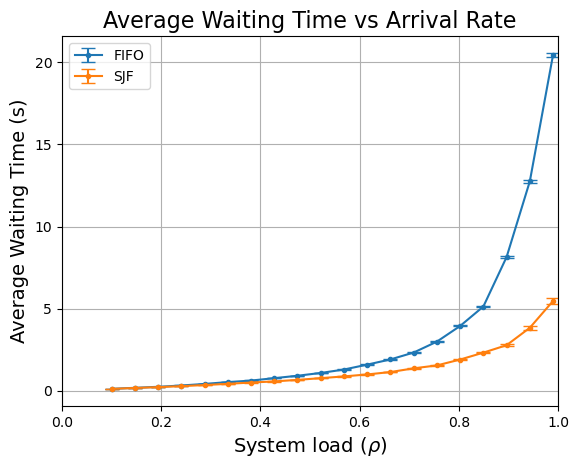

In [10]:
def source(env, time_total, Lambda, counter, waiting_times, mu, sjf=False):
    """Generates customers and puts them into the queue."""
    for i in range(time_total):
        if sjf:
            service_time = random.expovariate(mu)
            c = customer_sjf(env, f'Customer{i:02d}', counter, waiting_times, service_time)
        else:
            c = customer(env, f'Customer{i:02d}', counter, waiting_times, mu)
        env.process(c)
        t = random.expovariate(Lambda)
        yield env.timeout(t)

def customer(env, name, counter, waiting_times, mu):
    """Customer process for FIFO scheduling."""
    arrive = env.now
    with counter.request() as req:
        yield req
        wait = env.now - arrive
        waiting_times.append(wait)
        time_in = random.expovariate(mu)
        yield env.timeout(time_in)

def customer_sjf(env, name, counter, waiting_times, service_time):
    """Customer process for SJF scheduling."""
    arrive = env.now
    with counter.request(priority=service_time) as req:  # Add service time as priority
        yield req
        wait = env.now - arrive
        waiting_times.append(wait)
        yield env.timeout(service_time)

def run_simulation(num_servers, N, Lambda, mu, time_total, sjf=False):
    """Runs the simulation and returns the average waiting time."""
    timer = []
    for _ in range(N):
        env = simpy.Environment()
        if sjf:
            counter = simpy.PriorityResource(env, capacity=num_servers)
        else:
            counter = simpy.Resource(env, capacity=num_servers)
        
        env.process(source(env, time_total, Lambda, counter, timer, mu, sjf))
        env.run()

    average = np.mean(timer)
    ci = st.t.interval(0.95, len(timer)-1, loc=average, scale=st.sem(timer))
    error = (ci[1] - ci[0]) / 2
    return average, error

mu = 1
Lambda_values = np.linspace(0.1, 0.99, 20)
time_total = 1000
N = 100

collected_times_fifo = []
collected_times_sjf = []

errors_fifo = []
errors_sjf = []

for Lambda in Lambda_values:
    # FIFO scheduling
    avg_wait_fifo, fifo_error = run_simulation(1, N, Lambda, mu, time_total, sjf=False)
    collected_times_fifo.append(avg_wait_fifo)
    errors_fifo.append(fifo_error)

    # SJF scheduling
    avg_wait_sjf, sjf_error = run_simulation(1, N, Lambda, mu, time_total, sjf=True)
    collected_times_sjf.append(avg_wait_sjf)
    errors_sjf.append(sjf_error)

# Plotting the results
# plt.plot(Lambda_values, collected_times_fifo, 'o-', label='FIFO')
# plt.plot(Lambda_values, collected_times_sjf, 's--', label='SJF')

plt.errorbar(Lambda_values, collected_times_fifo, yerr=errors_fifo, 
            label='FIFO', fmt= 'o-',
            capsize=5,markersize=3)
plt.errorbar(Lambda_values, collected_times_sjf, yerr=errors_sjf, 
            label='SJF', fmt= 'o-',
            capsize=5,markersize=3)
plt.xlabel(r'System load ($\rho$)', fontsize = 14)
plt.ylabel('Average Waiting Time (s)', fontsize = 14)
plt.title('Average Waiting Time vs Arrival Rate', fontsize = 16)
#plt.yscale('log')
plt.legend()
plt.grid(True)
plt.xlim(0,1)
plt.savefig('Fifo_vs_Sjf.png', dpi = 400)
plt.show()

#### Question 4)

In this part we will experiment with different service rate distributions.

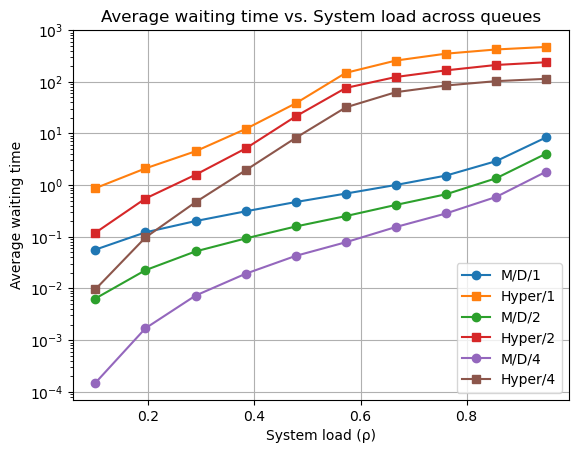

In [ ]:

def deterministic_service_time(mu):
    return 1 / mu

def hyperexponential_service_time():
    if random.random() < 0.75:
        return random.expovariate(1)
    else:
        return random.expovariate(1 / 5)
        
# the generalized customer process is defined as...
def customer(env, name, counter, waiting_times, service_time_fn):
    arrive = env.now
    with counter.request() as req:
        yield req
        wait = env.now - arrive
        waiting_times.append(wait)
        yield env.timeout(service_time_fn())

# ... with the simnulation runner...
def run_simulation(num_servers, rho_values, time_total, N, service_time_fn):
    results = []
    for rho in rho_values:
        waiting_times = []
        Lambda = rho * num_servers  # Arrival rate
        for _ in range(N):
            env = simpy.Environment()
            counter = simpy.Resource(env, capacity=num_servers)
            env.process(source(env, time_total, Lambda, counter, waiting_times, service_time_fn))
            env.run()
        avg_wait = np.mean(waiting_times)
        results.append(avg_wait)
    return results

def source(env, time_total, Lambda, counter, waiting_times, service_time_fn):
    for i in range(time_total):
        env.process(customer(env, f'Customer{i:02d}', counter, waiting_times, service_time_fn))
        yield env.timeout(random.expovariate(Lambda))

num_servers_list = [1, 2, 4]      #  the transition from simple to moderately scaled systems
rho_values = np.linspace(0.1, 0.95, 10)
time_total = 1000
N = 100

# here we will store the results for M/D/n and hyperexponential queues
results_md = {}
results_hyper = {}

for n in num_servers_list:
    results_md[n] = run_simulation(n, rho_values, time_total, N, lambda: deterministic_service_time(1))
    results_hyper[n] = run_simulation(n, rho_values, time_total, N, hyperexponential_service_time)

# and plot the results...
for n in num_servers_list:
    plt.plot(rho_values, results_md[n], label=f'M/D/{n}', marker='o')
    plt.plot(rho_values, results_hyper[n], label=f'Hyper/{n}', marker='s')

plt.xlabel('System load (ρ)')
plt.ylabel('Average waiting time')
plt.title('Average waiting time vs. System load across queues')
plt.yscale('log')
plt.legend()
plt.grid(True)

plt.show()
